## Final Model Inference

Example of inference pipeline for the final model using a secondary dataset (i.e., not used for training the model).  After the inference, error analysis is done to understand the results and see how well the final model can generalize.

**Data preprocessing**: Resize to 224x224, binarize, and apply n=2 morphological thinning.

**Model**: Classification model from the Yu, et al [paper](https://ieeexplore.ieee.org/document/8815875) used to classify all defects, including nones.

**Data**: Single-defect samples from the MixedWM38 dataset, a GAN-produced synthetic dataset from Wang, et al [GitHub](https://github.com/Junliangwangdhu/WaferMap).

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

# !pip install pickle5
import pickle5 as pickle

import boto3
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

import helpers as helper
from keras_model_s3_wrapper import *

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the data

Data is housed and loaded directly from an S3 bucket. Data was cleaned prior to loading into the bucket, and contains the following columns:
- **waferMap**: numpy array containing defect data of wafer map where 0 = blank spot, 1 = normal die (passed the electrical test), and 2 = broken die (failed electrical test)
- **ID**: unique identification for each waferMap
- **classifyLabels**: defect classification labels, where 0 = Loc, 1 = Edge-Loc, 2 = Center, 3 = Edge-Ring, 4 = Scratch, 5 = Random, 6 = Near-full, 7 = Donut, 8 = none

In [5]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = 'processed_data/customer/MixedWM38-single.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")

Wall time: 0.51 seconds
Dataset length: 8015


#### Dataset Failure Type Distribution
Quick EDA showing that the MixedWM38 single defect samples have a nearly uniform distribution for almost all the defect types.

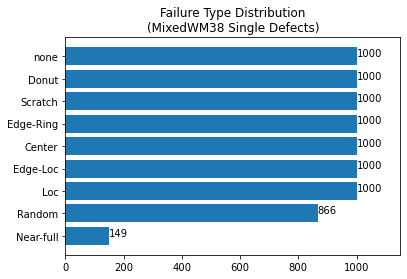

In [6]:
# show failure type distribution
helper.defect_distribution(data, note='MixedWM38 Single Defects')

### Data preprocessing

In [7]:
# resize to 224x224 --> binarize --> apply n=2 morphological thinning
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    thin_img = thin(thresh_img, 2)
    return thin_img
    
data['thinMap2'] = data.waferMap.apply(lambda x: preprocess(x))
data['thinMap2'] = data.thinMap2.apply(lambda x: x.astype(np.uint8))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.thinMap2[0].shape}')
print(f'Map unique values:{np.unique(data.thinMap2[0])}')

Wall time: 50.93 seconds
Sanity checks:
Map shape: (224, 224)
Map unique values:[0 1]


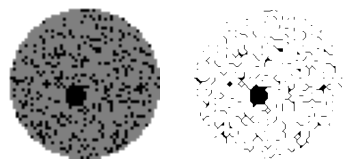

In [8]:
# sanity check
fig, ax = plt.subplots(1, 2)
ax[0].imshow(data.waferMap[0], cmap='gray_r')
ax[0].axis('off')
ax[1].imshow(data.thinMap2[0], cmap='gray_r')
ax[1].axis('off')
plt.show
pass

### Model Inference
#### Data set-up
Ensure that the data and labels are the correct shape expected by the model.

In [9]:
# prepare inputs
start = time.time()

x_cls = np.stack(data['thinMap2'])
x_cls = tf.expand_dims(x_cls, axis=3, name=None)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_cls.shape

Wall time: 1.29 seconds


TensorShape([8015, 224, 224, 1])

In [10]:
# prepare labels for evaluating results
y_cls = np.asarray(data['classifyLabels']).astype(np.uint8)

# sanity check
y_cls.shape

(8015,)

#### Load and run model
Trained final model is stored in S3 - it needs to be loaded before it can be used for inference.

In [11]:
# load saved classify model from S3
start = time.time()

classify = s3_get_keras_model('wafermap_final_model')
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 1)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        3

In [12]:
# generate predictions
start = time.time()

classify_pred = classify.predict(x_cls)
cls_labels = np.argmax(classify_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))

Wall time: 7.25 seconds


### Analyze Model Results
#### Visualize the results
Compute overall model accuracy and plot confusion matrix to understand model results.

In [ ]:
# # save predictions to local instance
# predictions = [classify_pred, cls_labels]
# with open(f'{result_path}/{result_filename}.pkl', "wb") as f:
#     pickle.dump(predictions, f)

Overall Model Accuracy: 76.02%


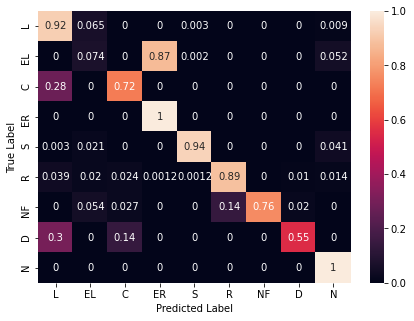

In [14]:
# manually compute overall accuracy
cls_cm = confusion_matrix(data['classifyLabels'], cls_labels)

cls_num = 0
for i in range(9):
    cls_num += cls_cm[i][i]

overall_accuracy = cls_num / len(data['classifyLabels']) * 100
print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

# plot confusion matrix
helper.plot_confusion_matrix(data['classifyLabels'], cls_labels, mode='all', normalize=True)

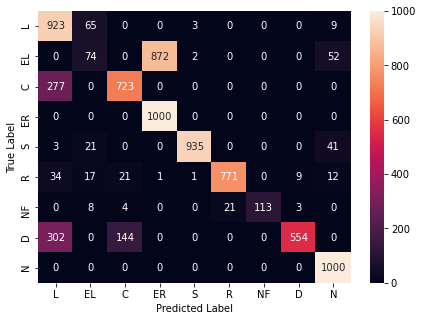

In [15]:
# plot confusion matrix counts
helper.plot_confusion_matrix(data['classifyLabels'], cls_labels, mode='all', normalize=False)

#### Error Analysis
Overall model accuracy is lower than expected, given the final model's results using the held-out test set (~97%). Where is the model making the most mistakes? Looking at the confusion matrix, we identified three sets of classes to investigate further:
1. Edge-Loc misclassified as Edge-Ring
2. Center misclassified as Loc
3. Near-full misclassified as Random

In [ ]:
# # find examples to plot
# import random

# defects = [i for i in range(len(test)) if (test.failureType.loc[i] == 'Near-full' and test.y_pred.loc[i] == 6)]
# print(len(defects))
# random_n = random.sample(defects, 10)
# random_n

Plotting random samples of each set, we start to see why the model gets confused. 

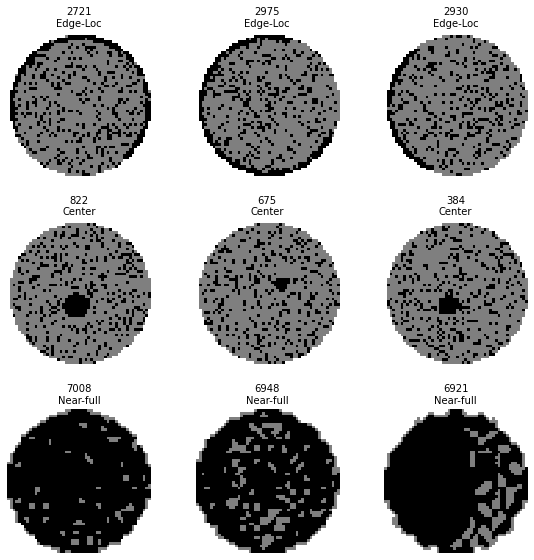

In [16]:
# examples to plot
ex = [2721, 822, 7008, 2975, 675, 6948, 2930, 384, 6921]
helper.plot_list(data, ex, cmap='gray_r', fig_size=(8,8))

### Re-analyzing Results
The classes we picked to investigate further are those that can potentially be combined. Edge-Loc and Edge-Ring defects have similar defect mechanisms. Center can be thought of as a subset of Loc. And the distinction between Random and Near-full is just the density of the defects in the wafermap.

When we re-analyze the results combining these three classes, we get a better overall accuracy that better represents how well our model can generalize.

In [17]:
# add predictions to data df
data['y_pred'] = cls_labels

# combine the following defects:
# E = EL + ER, L = L + C, R = R + NF
newFailDict = {0: 'L', 1: 'E', 2: 'S', 3: 'R', 4: 'D', 5: 'N'}
translator = {0: 0, 1: 1, 2: 0, 3: 1, 4: 2, 5: 3, 6: 3, 7: 4, 8: 5}

data['y_test2'] = data.classifyLabels.apply(lambda x: translator[x])
data['y_pred2'] = data.y_pred.apply(lambda x: translator[x])

data.head()

,ID,waferMap,labels,label_total,failureType,detectLabels,classifyLabels,thinMap2,y_pred,y_test2,y_pred2
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0,0
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0,0
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0,0
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0,0


Overall Model Accuracy: 90.62%


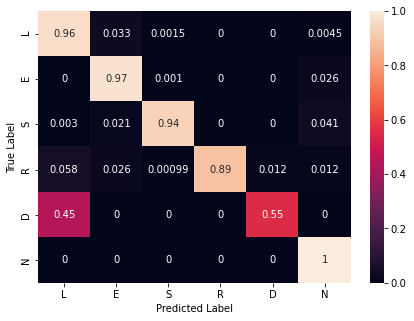

In [21]:
# manually compute overall accuracy
cls_cm2 = confusion_matrix(data['y_test2'], data['y_pred2'])

cls_num2 = 0
for i in range(6):
    cls_num2 += cls_cm2[i][i]

overall_accuracy = cls_num2 / len(data['y_test2']) * 100
print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

# plot confusion matrix
helper.plot_confusion_matrix(data['y_test2'], data['y_pred2'], mode='combo', normalize=True)

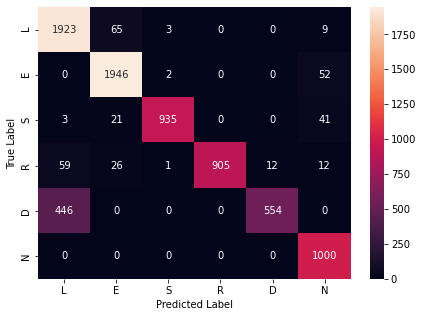

In [22]:
# plot confusion matrix counts
helper.plot_confusion_matrix(data['y_test2'], data['y_pred2'], mode='combo', normalize=False)